## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

import utils

## Part 1 Toy Problem (20 pts)

In [3]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2

    :param toy_img: numpy.ndarray
    """

    # Initialization
    H, W = img.shape
    im2var = np.arange(H*W).reshape(H, W)

    total = 2*(H-1)*(W-1)+W+H-1
    A = np.zeros((total, H*W))
    b = np.zeros(total)
    e = 0

    # object 3
    A[e][im2var[0][0]] = 1
    b[e] = img[0][0]
    e += 1

    for x in range(W):
        for y in range(H):

            # object 1
            if x < W - 1:
                A[e][im2var[y][x+1]] = 1
                A[e][im2var[y][x]] = -1
                b[e] = img[y][x+1] - img[y][x]
                e += 1

            # object 2
            if y < H - 1:
                A[e][im2var[y+1][x]] = 1
                A[e][im2var[y][x]] = -1
                b[e] = img[y+1][x] - img[y][x]
                e += 1

    v = scipy.sparse.linalg.lsqr(A, b, atol=1e-14, btol=1e-14)[0]
    return v.reshape(H, W)

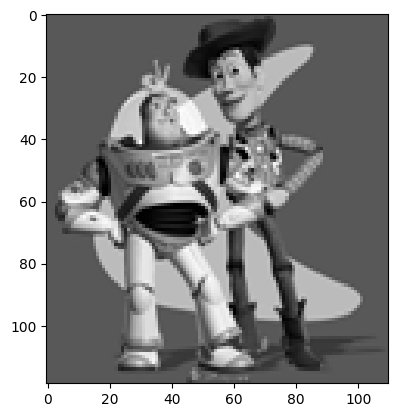

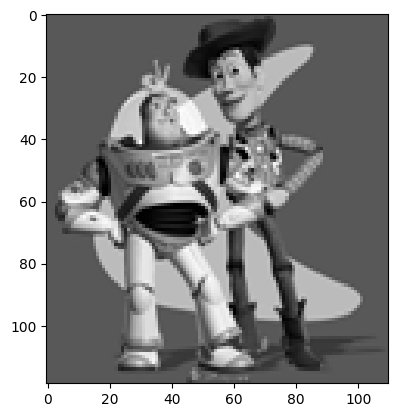

Max error is:  7.420508651989621e-12


In [4]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Part 2 Poisson Blending (50 pts)

### Preparation

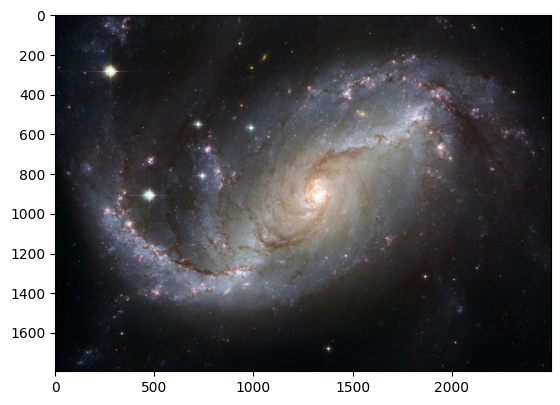

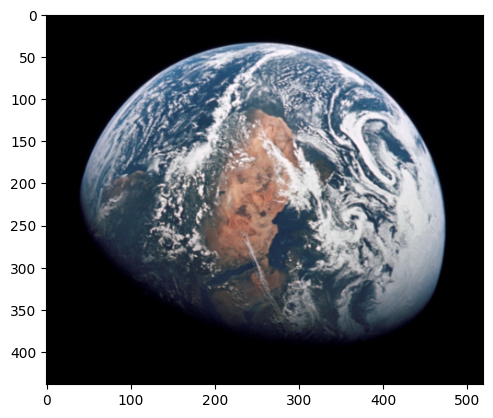

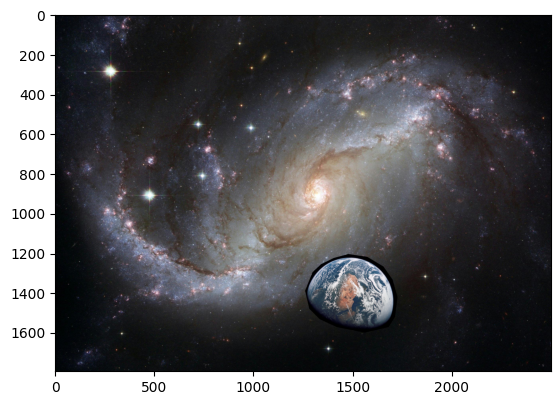

In [67]:
background_img = cv2.cvtColor(cv2.imread('samples/universe.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
# background_img = cv2.cvtColor(cv2.imread('samples/horizon.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/earth.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
# object_img = cv2.cvtColor(cv2.imread('samples/dophin2.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
# object_img = cv2.cvtColor(cv2.imread('samples/dophin.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
    # result 1
    xs = (174, 110, 67, 29, 50, 102, 189, 329, 450, 482, 495, 470, 424, 342, 247)
    ys = (35, 66, 106, 200, 290, 343, 383, 411, 383, 332, 232, 144, 78, 29, 15)
    bottom_center = (1500, 1600) # (x,y)
    
    # result 2
    # xs = (62, 36, 8, 10, 41, 57, 84, 116, 175, 186, 210, 213, 222, 188, 160, 163, 150, 117, 89)
    # ys = (7, 21, 30, 43, 56, 77, 81, 80, 99, 126, 130, 108, 77, 74, 58, 38, 19, 6, 4)
    # bottom_center = (150, 530) # (x,y)
    
    # result 3
    # xs = (60, 46, 27, 19, 4, 4, 25, 53, 60, 81, 97, 128, 130, 118, 113, 104, 101, 107, 127, 114, 124, 140, 136, 117, 89)
    # ys = (8, 21, 47, 59, 72, 85, 97, 130, 151, 164, 176, 175, 166, 161, 143, 115, 98, 79, 78, 51, 38, 25, 9, 5, 2)
    # bottom_center = (700, 530) # (x,y)
    
    object_mask = utils.get_mask(ys, xs, object_img)
    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
    combined_img = utils.get_combined_img(background_img, object_img, object_mask, bg_ul)
    plt.imshow(combined_img)
    # plt.imsave("./results/part2_simple_result1.png", combined_img)

### Poisson Blending

In [64]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    # get all nonzeros indices
    rows, cols = np.nonzero(object_mask)

    # construct im2var
    im2var = np.full(object_mask.shape,-1,dtype=int)
    for i, (r, c) in enumerate(zip(rows, cols)):
        im2var[r][c] = i

    data, row_ind, col_ind = [], [], []
    b = np.zeros(4*len(rows))
    e = 0
    increments = [(-1,0), (1,0), (0,-1), (0,1)]

    for r, c in zip(rows, cols):
        for inc in increments:
            nr, nc = r+inc[0], c+inc[1]

            row_ind.append(e)
            col_ind.append(im2var[r][c])
            data.append(1)

            if object_mask[nr][nc]:
                row_ind.append(e)
                col_ind.append(im2var[nr][nc])
                data.append(-1)
                b[e] = object_img[r][c] - object_img[nr][nc]
            else:
                tnr, tnc = bg_ul[0]+nr-1, bg_ul[1]+nc-1
                b[e] = bg_img[tnr][tnc] + object_img[r][c] - object_img[nr][nc]

            e += 1
    
    A = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=(e, len(rows)))
    v = scipy.sparse.linalg.lsqr(A, b, atol=1e-14, btol=1e-14)[0]
    v = np.clip(v, 0.0, 1.0)
    
    # paste to background image
    for i, (r, c) in enumerate(zip(rows, cols)):
        tr, tc = bg_ul[0]+r-1, bg_ul[1]+c-1
        bg_img[tr][tc] = v[i]
    
    return bg_img

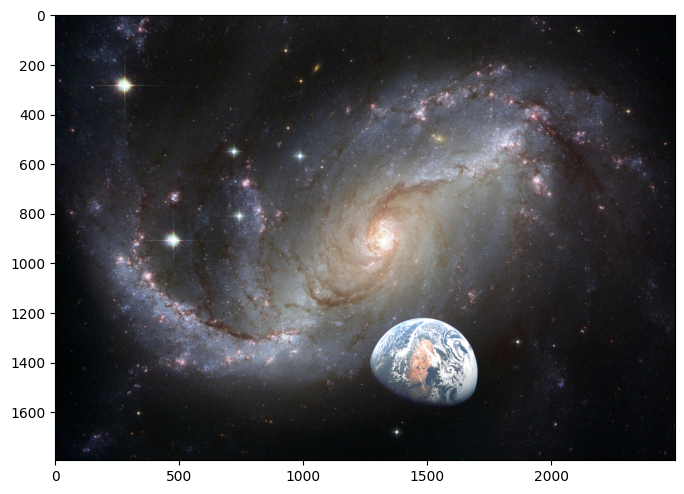

In [68]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
    im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(8,8))
plt.imshow(im_blend)

In [69]:
# plt.imsave("./results/part2_result1.png", im_blend)

## Part 3 Mixed Gradients (20 pts)

### Preparation

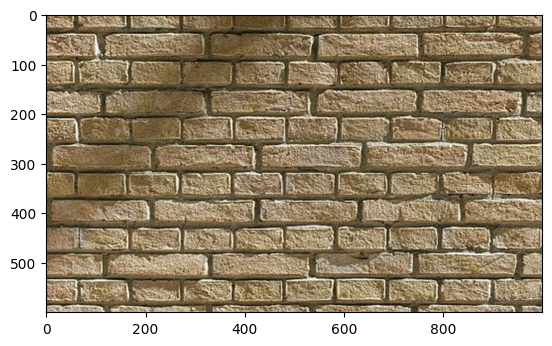

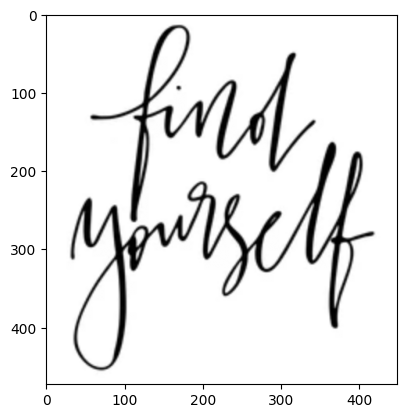

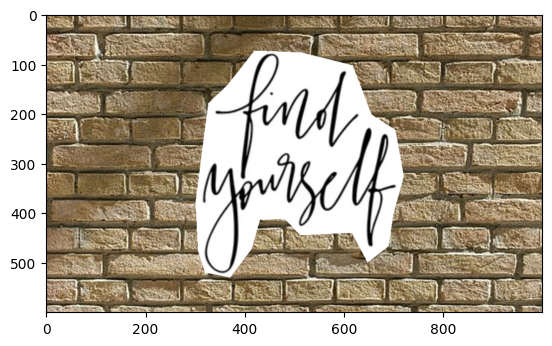

In [58]:
background_img = cv2.cvtColor(cv2.imread('samples/wall.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/writing.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
    # result 1
    xs = (135, 80, 42, 33, 16, 21, 35, 86, 129, 146, 196, 227, 331, 363, 405, 415, 436, 419, 371, 333, 230)
    ys = (7, 77, 113, 180, 313, 410, 454, 464, 407, 348, 346, 379, 374, 434, 401, 336, 260, 167, 136, 37, 11)
    bottom_center = (500, 530) # (x,y)
    
    object_mask = utils.get_mask(ys, xs, object_img)
    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
    combined_img = utils.get_combined_img(background_img, object_img, object_mask, bg_ul)
    plt.imshow(combined_img)
    plt.imsave("./results/part3_simple_result.png", combined_img)

### Mixed Gradients Blending

In [54]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    def get_grad(r, c, nr, nc):
        s_grad = object_img[r][c] - object_img[nr][nc]
        
        tr, tc = bg_ul[0]+r-1, bg_ul[1]+c-1
        tnr, tnc = bg_ul[0]+nr-1, bg_ul[1]+nc-1
        t_grad = bg_img[tr][tc] - bg_img[tnr][tnc]

        return s_grad if abs(s_grad) > abs(t_grad) else t_grad
    
    # get all nonzeros indices
    rows, cols = np.nonzero(object_mask)

    # construct im2var
    im2var = np.full(object_mask.shape,-1,dtype=int)
    for i, (r, c) in enumerate(zip(rows, cols)):
        im2var[r][c] = i

    data, row_ind, col_ind = [], [], []
    b = np.zeros(4*len(rows))
    e = 0
    increments = [(-1,0), (1,0), (0,-1), (0,1)]

    for r, c in zip(rows, cols):
        for inc in increments:
            nr, nc = r+inc[0], c+inc[1]

            row_ind.append(e)
            col_ind.append(im2var[r][c])
            data.append(1)

            grad = get_grad(r, c, nr, nc)
            
            if object_mask[nr][nc]:
                row_ind.append(e)
                col_ind.append(im2var[nr][nc])
                data.append(-1)
                b[e] = grad
            else:
                tnr, tnc = bg_ul[0]+nr-1, bg_ul[1]+nc-1
                b[e] = bg_img[tnr][tnc] + grad

            e += 1
    
    A = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=(e, len(rows)))
    v = scipy.sparse.linalg.lsqr(A, b, atol=1e-14, btol=1e-14)[0]
    v = np.clip(v, 0.0, 1.0)
    
    # paste to background image
    for i, (r, c) in enumerate(zip(rows, cols)):
        tr, tc = bg_ul[0]+r-1, bg_ul[1]+c-1
        bg_img[tr][tc] = v[i]
    
    return bg_img

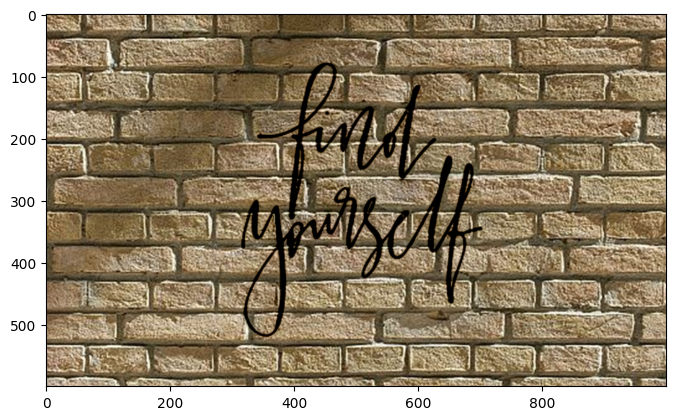

In [59]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
    im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(8,8))
plt.imshow(im_mix)

In [60]:
plt.imsave("./results/part3_result.png", im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)